# A Story about Hockey and Shooting

## Introduction

There has been considerable growth in advanced statistics for professional hockey in the last few years. One common family of stats is the so-called Corsi stats, which consider shot attempts. Traditionally, shots on goal was the stat seen in box scores, but Corsi expands this by defining shot attempts as shots on goal + shots missed + shots blocked (there is a parallel family of stats called Fenwick stats, that ignore blocked shots). More specifically, there is a player statistic called "Corsi-for percentage" or CF%, which is defined as:

$\textrm{ CF%(player X)} = \frac{\textrm{No. shot attempts for X's team | X on-ice}}{\textrm{No. shot attempts for both teams | X on-ice}}$

This stat evaluates how a player contributes to producing shot attempts for his team while preventing shot attempts against his team. It does not require the player to shoot himself as there are other ways to contribute (passing and defense, for example). Two advantages of this metric are 1) it combines offensive and defensive merit and 2) it enlarges the data set.

The NHL publishes online game-by-game logs that record shot attempts. For example:
http://www.nhl.com/scores/htmlreports/20152016/PL0003.HTM is the game log for the third game of the 2015-2016 season. I have built a data scraper that downloads the HTML files and constructs a matrix of which players were on-ice for all shot attempts. I have a python class that manages this data called ```attempt_manager```:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import attempt_manager as am
AM = am.attempt_manager()
AM.Load()

Loading data...
...done


Here is the breakdown of shot attempts and players (excluding goalies):

In [2]:
print 'Number of non-goalies that dressed in 2015-16: {}'.format(len(AM.NGs))

t_dict = {'G': 'Goals', 'S': 'Shots saved', 'M': 'Shot missed', 'B': 'Shots blocked'}
for k in t_dict.keys():
    print t_dict[k] + ': ' + str(AM.attempt_type.count(k))
print 'Total shot attempts: {}'.format( AM.no_att ) 

Number of non-goalies that dressed in 2015-16: 900
Shots saved: 66601
Shots blocked: 34845
Shot missed: 28519
Goals: 6565
Total shot attempts: 136530


One immediate and easy question to ask is whether or not there is a home-ice advantage: 

In [3]:
print 'Home goals: {}'.format( sum( pd.Series( AM.attempt_type)[AM.home_indices] == 'G') )
print 'Away goals: {}'.format(AM.attempt_type.count('G') - sum( (pd.Series( AM.attempt_type)[AM.home_indices] == 'G') ))

print 'Home shot attempts: {}'.format(len(AM.home_indices))
print 'Away shot attempts: {}'.format( AM.no_att - len(AM.home_indices) )


Home goals: 3404
Away goals: 3161
Home shot attempts: 70468
Away shot attempts: 66062


As we can see, the home-ice advantage is real and reflected in both goals and shot-attempts. In fact, the sparse matrix that I use to store the data has a column each for a player at home and a player away, so that there are 1800 rather than 900 features:

In [4]:
print AM.att_matrix.shape

(136530, 1800)


## Do shot attempts help win the game?

Goals, not shot attempts, are what win games. So we would should examine the correlation between them. 

In [5]:
import summary_manager as sm

SM = sm.summary_manager()
SM.Load()
print SM.summary.head()

Loading data...
...done
   Home goals  Home shots  Home misses  Home blocks  Home Corsi  Away goals  \
0           1          36           14           15          66           3   
1           2          32           14           15          63           3   
2           1          29           11           13          54           5   
3           1          19           11           13          44           5   
4           2          29           19           13          63           6   

   Away shots  Away misses  Away blocks  Away Corsi  
0          26           16            9          54  
1          24           11            3          41  
2          39           11           10          65  
3          27           12           10          54  
4          26            9            9          50  


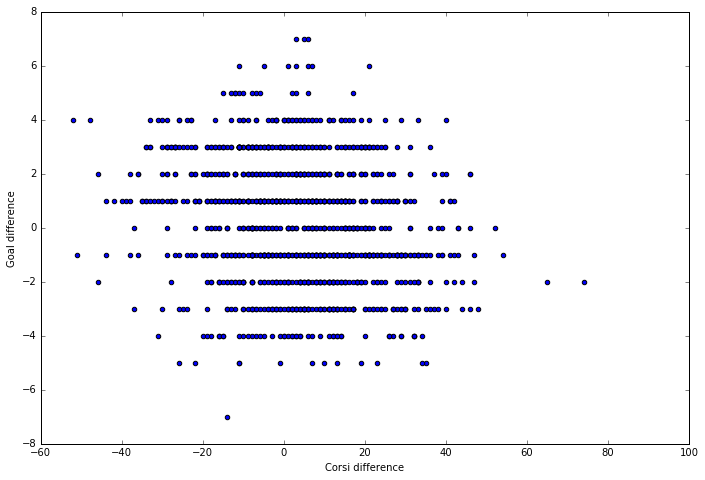

In [6]:
goal_diff = SM.summary['Home goals'] - SM.summary['Away goals']
Corsi_diff = SM.summary['Home Corsi'] - SM.summary['Away Corsi']

fig = plt.figure()
ax = fig.add_axes([.1,.1,1.5,1.5])
plt.xlabel('Corsi difference')
plt.ylabel('Goal difference')

ax.scatter(Corsi_diff, goal_diff)
plt.show()

In [44]:
LR = LinearRegression()
LR.fit( Corsi_diff.reshape(-1,1),goal_diff.reshape(-1,1))
print LR.intercept_, LR.coef_

[ 0.29287018] [[-0.02660697]]


Surprisingly, the answer appears to be: no, there is little difference between goal-scoring and Corsi. Of course, we have neglected an important factor: goalies. Presumably goalie skill strongly affects converting shot attempts into goals. Regardless, we should understand that shot attempts are not the only ingredient when it comes to winning.

## Corsi and quality of opponent

Using CF% to evaluate players also ignores an important aspect of hockey: line-matching. Unlike a game such as soccer, where there is little substitution, hockey rolls four forward lines and three defense lines, so that even the top players play less than half the game. And coaches will often strategize how to match up their lines with their opponents. The result is that top players have a higher degree of difficulty, because they will typically play stronger opponents. It is an interesting question as to how we can adjust this stat to compensate for this effect.

Two proxy statistics we can use to assess 'quality of opponent' (or at least the perception of quality) are player salary and player playing time. Salary is a little problematic, because younger players are certainly underpaid, and the production of older players can fall off after getting a fat contract. The latter statistic is probably better, because a coach can respond quickly to changes in playing quality, and because there is a decent spread in player time on ice (TOI):

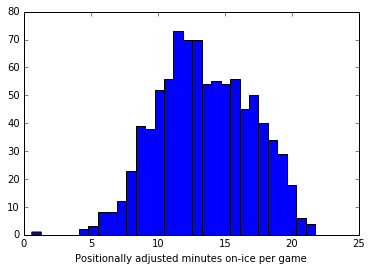

In [7]:
players = pd.read_csv('data/Directory.csv')
players=players[ ~players.TOI.isnull()]
plt.hist(players['paTOI/G'],bins=30)
plt.xlabel('Positionally adjusted minutes on-ice per game')
plt.show()

Note that "positionally adjusted" refers to the fact that defensemen play longer on average: there are three defense lines to four forward lines, so we compensate by multiplying defense TOI by 0.75.

If these statistics are both good measures of player quality, we should expect them to correlate:

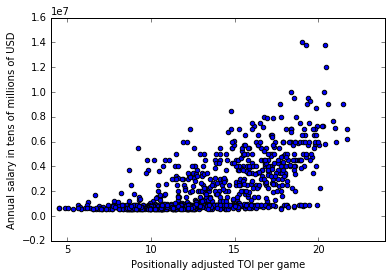

In [8]:
plt.scatter(players['paTOI/G'],players['Salary'])
plt.xlim(4,24)
plt.xlabel('Positionally adjusted TOI per game')
plt.ylabel('Annual salary in tens of millions of USD')
plt.show()

We see a clear correlation, although we can see a subgroup that is rather flat at the bottom. As it happens, entry-level contracts are capped at 925,000, so that subgroup represents the underpaid young players. For example:

In [78]:
players[ (players['Salary'] < 1000000)  & (players['paTOI/G'] > 19)]

,ID,Player,Position,Games Dressed,Salary,TOI,paTOI/G
14,15,ALEKSANDER BARKOV,C,66,925000,1282.383333,19.430051
345,346,FILIP FORSBERG,L,82,832500,1562.316667,19.052642
378,379,JACK EICHEL,C,81,925000,1548.850000,19.121605
473,474,JOHNNY GAUDREAU,L,79,925000,1574.516667,19.930591
872,873,SEAN MONAHAN,C,81,925000,1552.766667,19.169959


These players are all young hotshots: their ages are 20, 21, 19, 22 and 21, respectively. We should expect playing time to be a better measure than salary, because of the significant time lag in financial compensation with on-ice performance.

To support our claim that better players tend to share the ice with other better players, we consider the average salary and playing time for home players versus away players. ```attempt_manager``` has class variables recording this data. First, we remove penalty shots from the data, since penalty shots have no opponent on the ice other than the goalie. There aren't very many though (note that the data set does not include post-OT penalty shoot-outs):

In [9]:
pen_shots = (pd.Series(AM.home_OI_PT) < 1) | (pd.Series(AM.away_OI_PT) <1)
sum(pen_shots)

58

In [10]:
h_sal = pd.Series(AM.home_OI_sal)[~pen_shots]
a_sal = pd.Series(AM.away_OI_sal)[~pen_shots]
h_PT = pd.Series(AM.home_OI_PT)[~pen_shots]
a_PT = pd.Series(AM.away_OI_PT)[~pen_shots]

Visually it's difficult to tell whether there's a good correlation, especially with respect to salary:

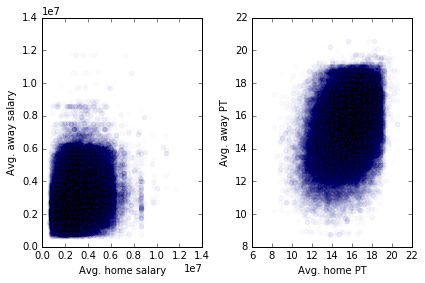

In [11]:
fig, ax = plt.subplots(1,2 )
ax[0].scatter(h_sal,a_sal, alpha=0.01)
ax[0].set_xlabel('Avg. home salary')
ax[0].set_ylabel('Avg. away salary')

ax[1].scatter(h_PT,a_PT, alpha=0.01)
ax[1].set_xlabel('Avg. home PT')
ax[1].set_ylabel('Avg. away PT')
plt.tight_layout()

If we run a linear regression however, we can see that, after proper scaling, there is a moderate salary correlation:

In [13]:
from sklearn.linear_model import LinearRegression

h_sal_norm = (h_sal-h_sal.mean())/h_sal.std()
a_sal_norm = (a_sal-a_sal.mean())/a_sal.std()

LR = LinearRegression()
LR.fit(h_sal_norm.reshape(-1,1),a_sal_norm.reshape(-1,1))
print LR.intercept_, LR.coef_

[  1.29639934e-14] [[ 0.14269522]]


And when we do the same to the playing time data, we get a correlation coefficient of 0.30. This is around what I would expect: a definite correlation, but enough 'cross-talk' between various lines that we get good players on the ice with not-so-good players at a reasonable clip.

In [14]:
h_PT_norm = (h_PT-h_PT.mean())/h_PT.std()
a_PT_norm = (a_PT-a_PT.mean())/a_PT.std()

LR = LinearRegression()
LR.fit(h_PT_norm.reshape(-1,1),a_PT_norm.reshape(-1,1))
print LR.intercept_, LR.coef_

[ -4.70227179e-14] [[ 0.30193169]]


We can now ask whether these two metrics affect shot attempts:

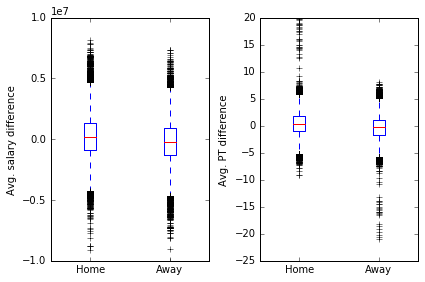

In [15]:
away_indices = list(set(range(0,len(AM.attempt_type))) - set(AM.home_indices))
away_indices.sort()
sal_diff = pd.DataFrame()
sal_diff_home = list(pd.Series(AM.home_OI_sal)[AM.home_indices]- pd.Series(AM.away_OI_sal)[AM.home_indices])
sal_diff_away = list(pd.Series(AM.home_OI_sal)[away_indices]- pd.Series(AM.away_OI_sal)[away_indices])
PT_diff_home = pd.Series(AM.home_OI_PT)[AM.home_indices]- pd.Series(AM.away_OI_PT)[AM.home_indices]
PT_diff_away = pd.Series(AM.home_OI_PT)[away_indices]- pd.Series(AM.away_OI_PT)[away_indices]

fig, ax = plt.subplots(1,2)
ax[0].boxplot([sal_diff_home,sal_diff_away])
ax[1].boxplot([PT_diff_home,PT_diff_away])
ax[0].set_ylabel('Avg. salary difference')
ax[1].set_ylabel('Avg. PT difference')
for j in [0,1]:
    ax[j].set_xticklabels(['Home','Away'] )
plt.tight_layout()

It is clear that effect size is actually quite small, and in the case of salary, there may not be any effect at all. Despite the very significant overlap in both cases, our sample size is very large, so we may get very large z-statistics anyway. 

In [16]:
import scipy.stats as sps 

sal_diff_mean_diff = np.mean(np.array(sal_diff_home)) - np.mean(np.array(sal_diff_away))
sal_diff_var_home = np.var(np.array(sal_diff_home))
sal_diff_var_away = np.var(np.array(sal_diff_away))
nh = len(sal_diff_home)
na = len(sal_diff_away)
sal_diff_error = np.sqrt( 1/ float(nh)+1/float(na)) * np.sqrt( (nh*sal_diff_var_home + nh*sal_diff_var_away)/ float(nh+na-2))

z_statistic = sal_diff_mean_diff / sal_diff_error
print 'Difference in salary discrepancy between home and away shot attempts: {}'.format(sal_diff_mean_diff)
print 'The z-score is: {}'.format(z_statistic)
print 'The probability that this is just a fluke is: {}'.format(1-sps.norm.cdf(z_statistic))

Difference in salary discrepancy between home and away shot attempts: 426308.743591
The z-score is: 44.9592485704
The probability that this is just a fluke is: 0.0


In [17]:
PT_diff_mean_diff = np.mean(np.array(PT_diff_home)) - np.mean(np.array(PT_diff_away))
PT_diff_var_home = np.var(np.array(PT_diff_home))
PT_diff_var_away = np.var(np.array(PT_diff_away))
nh = len(PT_diff_home)
na = len(PT_diff_away)
PT_diff_error = np.sqrt( 1/ float(nh)+1/float(na)) * np.sqrt( (nh*PT_diff_var_home + nh*PT_diff_var_away)/ float(nh+na-2))

z_statistic = PT_diff_mean_diff / PT_diff_error
print 'Difference in playing time discrepancy between home and away shot attempts: {}'.format(PT_diff_mean_diff)
print 'The z-score is: {}'.format(z_statistic)
print 'The probability that this is just a fluke is: {}'.format(1-sps.norm.cdf(z_statistic))

Difference in playing time discrepancy between home and away shot attempts: 0.665294931899
The z-score is: 57.9543230745
The probability that this is just a fluke is: 0.0


Both of the effect sizes (average salary bump of $436,000 and playing time bump of 36 seconds per 60 minutes) are rather small but definitely not trivial. Additionally, the large sample sizes allow us to conclude that these effects are very significant. If salary and playing time are good indicators of player ability, then the ability of players on the ice affects frequency of shot attempts. 

## Are two features better than one?

We have already mentioned that playing time is probably a better indicator of player ability than salary. Moreover, both variables are correlated, so is it necessary to consider both? More variables lead to overfitting and we don't want two features when only one is needed. 

Now, one can imagine reasons why salary could still be useful. Some older players may be quite skilled but with lower stamina. Therefore they may be well compensated, but given less playing time. A more important effect is that players on bad teams get more playing time than they deserve, because their competition is limited. Presumably their salary would not reflect this lower competition. Conversely, players on loaded teams may be well-paid to reflect their ability, but may see less ice-team because their teammates are good. This effect is probably mitigated considerably by the salary cap, but let us examine the data.

Let's create a third feature by projecting away PT from the salary data:

In [18]:
numerator1 = np.matrix(AM.home_OI_sal).dot(np.matrix(AM.home_OI_PT).T )[0,0]
denom1 = np.matrix(AM.home_OI_PT).dot(np.matrix(AM.home_OI_PT).T )[0,0]
adj_sal_home = np.matrix(AM.home_OI_sal) - numerator1/denom1 * np.matrix(AM.home_OI_PT)

numerator2 = np.matrix(AM.away_OI_sal).dot(np.matrix(AM.away_OI_PT).T )[0,0]
denom2 = np.matrix(AM.away_OI_PT).dot(np.matrix(AM.away_OI_PT).T )[0,0]
adj_sal_away = np.matrix(AM.away_OI_sal) - numerator2/denom2 * np.matrix(AM.away_OI_PT)

adj_sal_diff_home = np.array(adj_sal_home)[0][AM.home_indices] - np.array(adj_sal_away)[0][AM.home_indices]
adj_sal_diff_away = np.array(adj_sal_home)[0][away_indices] - np.array(adj_sal_away)[0][away_indices]

adj_sal_diff_mean_diff = np.mean(adj_sal_diff_home) - np.mean(adj_sal_diff_away)
adj_sal_diff_var_home = np.var(adj_sal_diff_home)
adj_sal_diff_var_away = np.var(adj_sal_diff_away)
nh = len(adj_sal_diff_home)
na = len(adj_sal_diff_away)
adj_sal_diff_error = np.sqrt( 1/ float(nh)+1/float(na)) * np.sqrt( (nh*adj_sal_diff_var_home + nh*adj_sal_diff_var_away)/ float(nh+na-2))

z_statistic = adj_sal_diff_mean_diff / adj_sal_diff_error
print 'Difference in adjusted salary discrepancy between home and away shot attempts: {}'.format( adj_sal_diff_mean_diff)
print 'The z-score is: {}'.format(z_statistic)
print 'The probability that this is just a fluke is: {}'.format(1-sps.norm.cdf(z_statistic))

Difference in adjusted salary discrepancy between home and away shot attempts: 285534.784257
The z-score is: 34.9461561288
The probability that this is just a fluke is: 0.0


So, the adjustment decreases the effect size, by slightly less than half. Yet the confidence in a significant result is still extremely high. The large sample size has lot to do with this, but as of now, the data indicates we should keep both variables.

One obvious way to proceed is to train a logistic regression model on both salary and playing time, but that is the next chapter ...
